In [ ]:
import os
import zipfile
import requests
from tqdm import tqdm
import requests
import os
from tqdm import tqdm

def download_file(url, filename):
    response = requests.get(url, stream=True, verify=False)
    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as f, tqdm(
        desc=filename,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = f.write(data)
            bar.update(size)


# Download and extract (cleared output lines, can run the cell to get the data)
if not os.path.exists('UCF101.rar'):
    print("Downloading UFC101 dataset...")
    download_file('https://www.crcv.ucf.edu/data/UCF101/UCF101.rar', 'UCF101.rar')

if not os.path.exists('UCF101'):
    print("Extracting UFC101 dataset...")
    !unrar x UCF101.rar

In [2]:
# Define the classes we want to keep
selected_classes = [
    'ApplyEyeMakeup',
    'PlayingDhol',
    'BabyCrawling',
    'Haircut',
    'SkyDiving',
    'Surfing',
    'Rafting',
    'CricketShot',
    'ShavingBeard'
]

filtered_dir = 'UCF101_filtered'
os.makedirs(filtered_dir, exist_ok=True)

for class_name in selected_classes:
    actual_class_name = class_name

    src_dir = f'UCF-101/{actual_class_name}'
    dst_dir = f'{filtered_dir}/{class_name}'

    if os.path.exists(src_dir):
        !cp -r "{src_dir}" "{dst_dir}"
    else:
        print(f"Warning: Class {class_name} not found in dataset")

### RGB Histogram

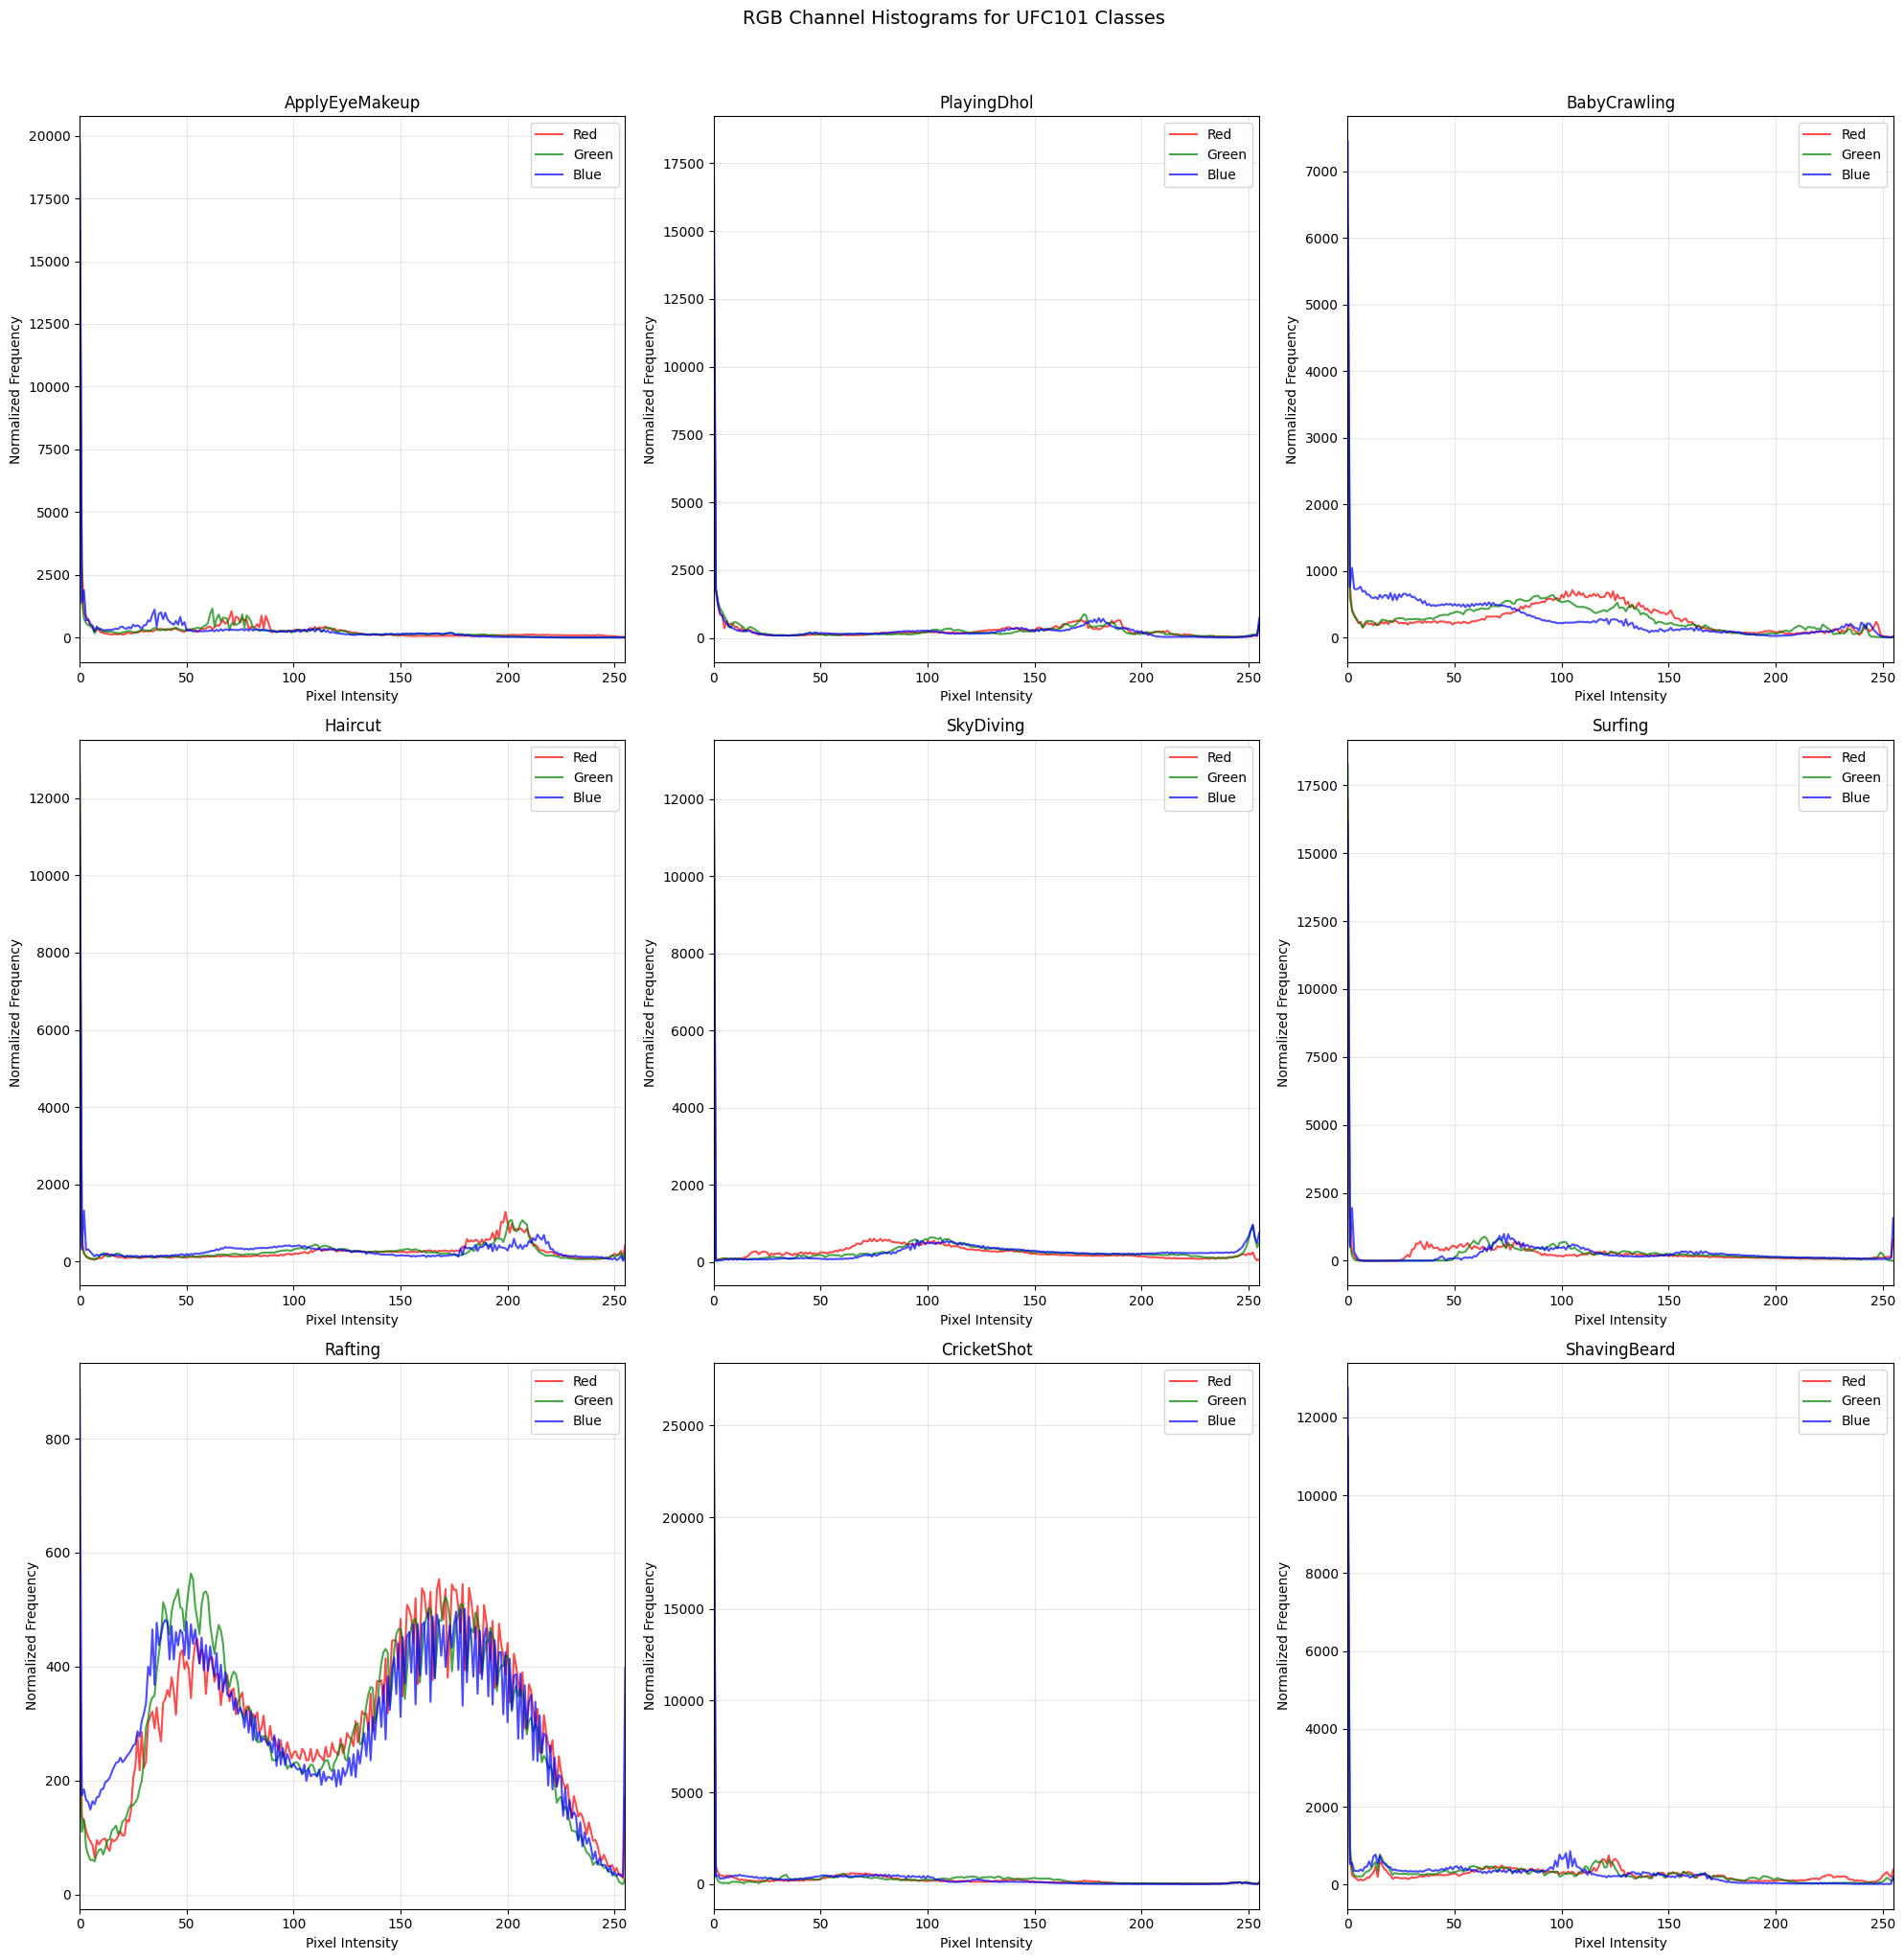

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

plt.figure(figsize=(20, 20))
plt.suptitle('RGB Channel Histograms for UFC101 Classes', y=1.02, fontsize=14)

# Process each class
for i, class_name in enumerate(selected_classes, 1):
    video_paths = glob(os.path.join(filtered_dir, class_name, '*.avi'))[:3]

    # Initialize histogram accumulators
    hist_r = np.zeros(256)
    hist_g = np.zeros(256)
    hist_b = np.zeros(256)
    frame_count = 0

    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Convert and calculate histograms
            for j, color in enumerate(['b','g','r']):
                hist = cv2.calcHist([frame], [j], None, [256], [0,256])
                if color == 'r':
                    hist_r += hist.flatten()
                elif color == 'g':
                    hist_g += hist.flatten()
                else:
                    hist_b += hist.flatten()
            frame_count += 1
        cap.release()

    # Normalize by frame count
    hist_r /= frame_count
    hist_g /= frame_count
    hist_b /= frame_count

    # Plot
    plt.subplot(3, 3, i)
    plt.plot(hist_r, 'r', label='Red', alpha=0.7)
    plt.plot(hist_g, 'g', label='Green', alpha=0.7)
    plt.plot(hist_b, 'b', label='Blue', alpha=0.7)
    plt.title(class_name)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Normalized Frequency')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim([0, 255])

plt.tight_layout()
plt.show()

### Optical flow

Processing optical flow for ApplyEyeMakeup...
Processing optical flow for PlayingDhol...
Processing optical flow for BabyCrawling...
Processing optical flow for Haircut...
Processing optical flow for SkyDiving...
Processing optical flow for Surfing...
Processing optical flow for Rafting...
Processing optical flow for CricketShot...
Processing optical flow for ShavingBeard...


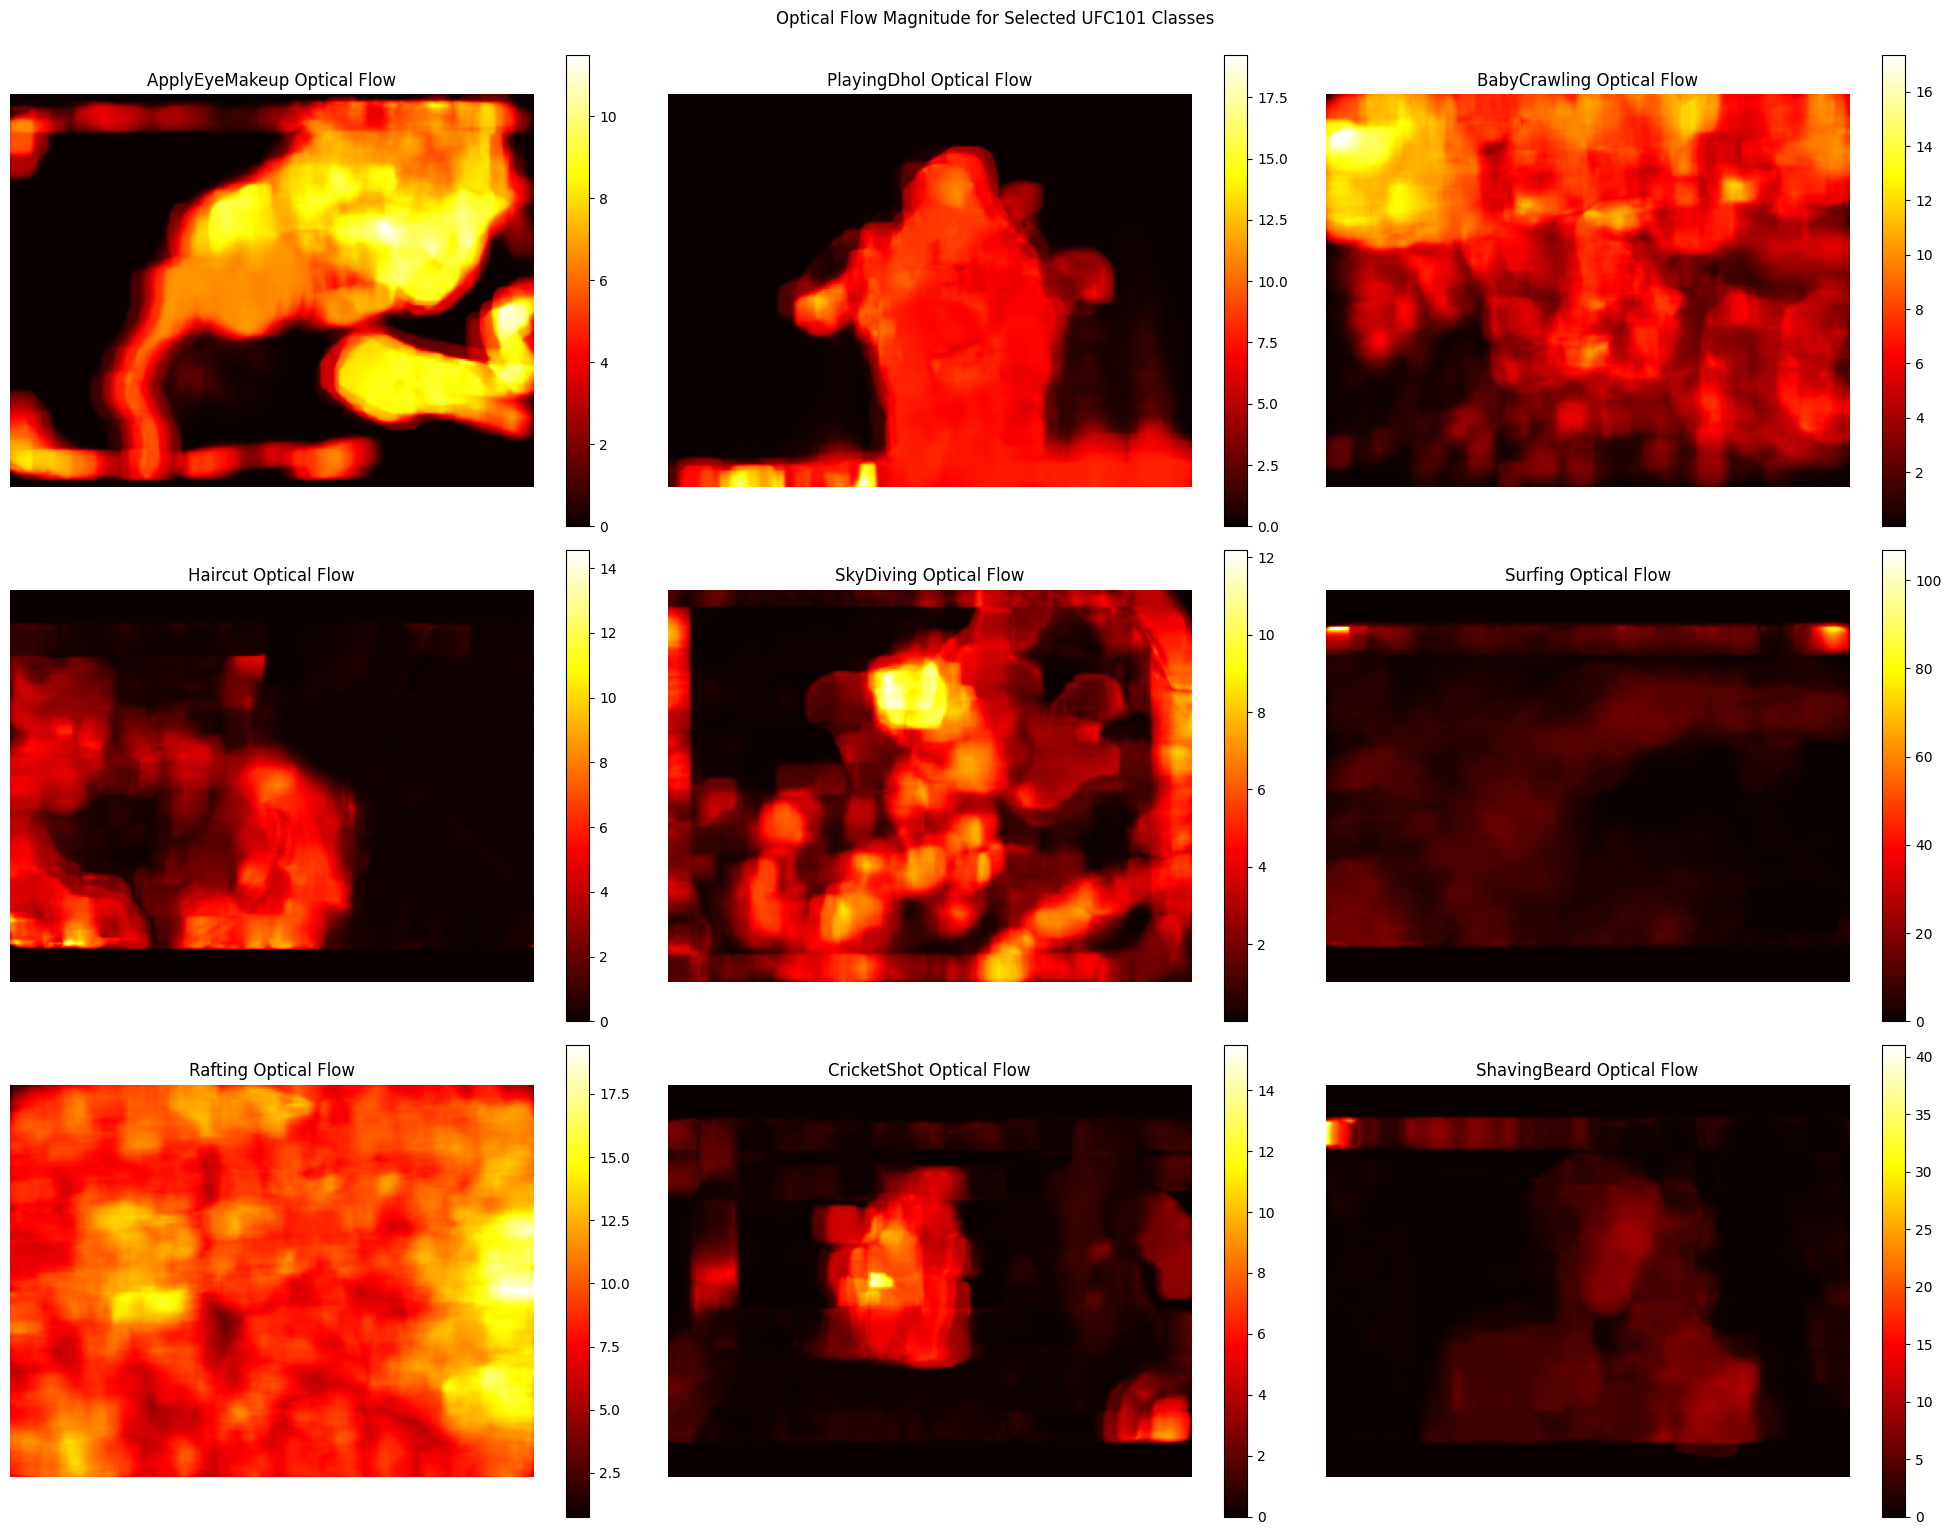

In [ ]:
def compute_optical_flow(video_path, num_frames=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    flow_magnitudes = []

    # Read first frame
    ret, prev_frame = cap.read()
    if not ret:
        return None

    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

    # Sample frames throughout the video
    for i in range(1, num_frames+1):
        frame_idx = int(i * (frame_count / (num_frames+1)))
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            magnitude, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            flow_magnitudes.append(magnitude)
            prev_gray = gray

    cap.release()

    if flow_magnitudes:
        avg_flow = np.mean(flow_magnitudes, axis=0)
        return avg_flow
    return None

# Compute optical flow for each class
class_flows = defaultdict(list)

for class_name in selected_classes:
    print(f"Processing optical flow for {class_name}...")
    video_files = glob(f'{filtered_dir}/{class_name}/*.avi')

    for video_path in video_files[:3]:
        flow = compute_optical_flow(video_path)
        if flow is not None:
            class_flows[class_name].append(flow)

# Visualize optical flow
plt.figure(figsize=(20, 15))

for i, (class_name, flows) in enumerate(class_flows.items()):
    if not flows:
        continue

    flow = flows[0]

    plt.subplot(3, 3, i+1)
    plt.imshow(flow, cmap='hot')
    plt.colorbar()
    plt.title(f'{class_name} Optical Flow')
    plt.axis('off')

plt.tight_layout()
plt.suptitle('Optical Flow Magnitude for Selected UFC101 Classes', y=1.02)
plt.show()